In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import GaussianNB


In [2]:
train_answers=pd.read_csv("train_answers.csv", sep=";",index_col=0)
test_answers=pd.read_csv("test_answers.csv", sep=";",index_col=0)

## Explore Data

In [3]:
train_answers.columns

Index(['dtset', 'qtype', 'stype', 'quest_id', 'question', 'ref_ans', 'st_answ',
       'id_st', 'st_ans_calif'],
      dtype='object')

In [4]:
trn_smpl=train_answers.sample(1)
[list(trn_smpl[dat]) for dat in trn_smpl]

[['TRAIN Beetle'],
 ['Q_EXPLAIN_SPECIFIC'],
 ['EVALUATE'],
 ['BURNED_BULB_PARALLEL_WHY_Q'],
 ['Why didn^t bulbs A and C go out after bulb B burned out?'],
 ['B is not in their paths'],
 ['there is still a closed path that contains the battery and bulb a and bulb c'],
 ['SwitchesBulbsParallel-BURNED_BULB_PARALLEL_WHY_Q.sbj42-l2.qa100'],
 [1]]

In [5]:
tst_smpl=test_answers.sample(1)
[list(tst_smpl[dat]) for dat in tst_smpl]

[['TEST sciEntsBank Unseen Domains'],
 [nan],
 [nan],
 ['WA_20b'],
 ['Ron covered his notebook with waxed paper. Then he placed a small drop of water in the middle of the notebook as shown in the picture. Even though the drop was on a slope, the drop stayed where he placed it. Describe 2 ways Ron can make the water move down the notebook without pushing the drop or blowing on it.'],
 ['Expand the drop. Tilt the notebook.'],
 ['Adding more water.'],
 ['WA.20b.395.1'],
 [1]]

# Preprocessing all data

In [6]:
complete_dataset=pd.concat([train_answers,test_answers], keys=['train', 'test'])# MultiIndexing Pandas

In [7]:
texts=np.array(complete_dataset["question"]+" "+complete_dataset["ref_ans"]+" "+complete_dataset["st_answ"])

## tf-idf matrix

In [8]:
count_vect = CountVectorizer()
txt_freqs = count_vect.fit_transform(texts)
txt_freqs.shape


(33763, 3931)

In [9]:
txt_freqs

<33763x3931 sparse matrix of type '<class 'numpy.int64'>'
	with 907433 stored elements in Compressed Sparse Row format>

In [10]:
tfidf_transformer = TfidfTransformer().fit(txt_freqs)
txt_tfidf=tfidf_transformer.transform(txt_freqs)

In [11]:
train_tfidf=txt_tfidf[complete_dataset.index.labels[0]==0,:]
train_tfidf_Y=train_answers["st_ans_calif"]
test_tfidf=txt_tfidf[complete_dataset.index.labels[0]==1,:]
test_tfidf_Y=test_answers["st_ans_calif"]

In [12]:
top_n=150
txt_freqs_sum= txt_freqs.toarray().sum(axis=0)
indices = np.argsort(txt_freqs_sum)[::-1]#np.argsort(vectorizer.idf_)[::-1]
features =count_vect.get_feature_names()# vectorizer.get_feature_names()
top_features = [[features[i],txt_freqs_sum[i]] for i in indices[:top_n]]
list(top_features)

[['the', 128985],
 ['and', 48205],
 ['is', 38743],
 ['in', 33215],
 ['of', 31076],
 ['terminal', 30816],
 ['to', 28797],
 ['bulb', 25137],
 ['are', 20014],
 ['why', 18688],
 ['path', 16850],
 ['battery', 16727],
 ['you', 15946],
 ['water', 15856],
 ['voltage', 13473],
 ['not', 13384],
 ['it', 13204],
 ['gap', 12946],
 ['was', 12880],
 ['closed', 12180],
 ['explain', 12001],
 ['on', 10622],
 ['there', 10506],
 ['when', 10017],
 ['same', 9967],
 ['positive', 9940],
 ['for', 9537],
 ['switch', 9513],
 ['what', 9280],
 ['that', 9012],
 ['because', 8761],
 ['with', 8446],
 ['out', 8393],
 ['terminals', 8251],
 ['circuit', 8022],
 ['does', 8000],
 ['reading', 7517],
 ['electrical', 7179],
 ['connected', 7145],
 ['one', 6281],
 ['or', 6146],
 ['if', 6121],
 ['got', 6121],
 ['between', 6011],
 ['open', 5672],
 ['different', 5651],
 ['no', 5602],
 ['from', 5334],
 ['by', 5193],
 ['states', 5162],
 ['will', 5090],
 ['bulbs', 5054],
 ['be', 4915],
 ['she', 4895],
 ['how', 4803],
 ['they', 4786],


Text(0.5, 1.0, 'tf_idf sorted')

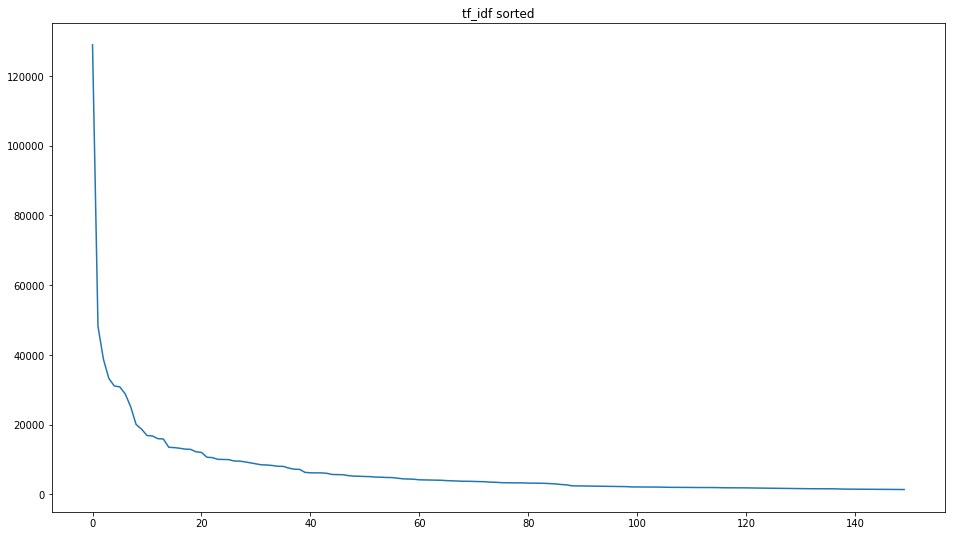

In [13]:
plt.figure(figsize=(16,9))
plt.plot(txt_freqs_sum[indices[:top_n]])
plt.title("tf_idf sorted")
# txt_freqs[indices[:top_n]]

Text(0.5, 1.0, 'tf_idf matrix')

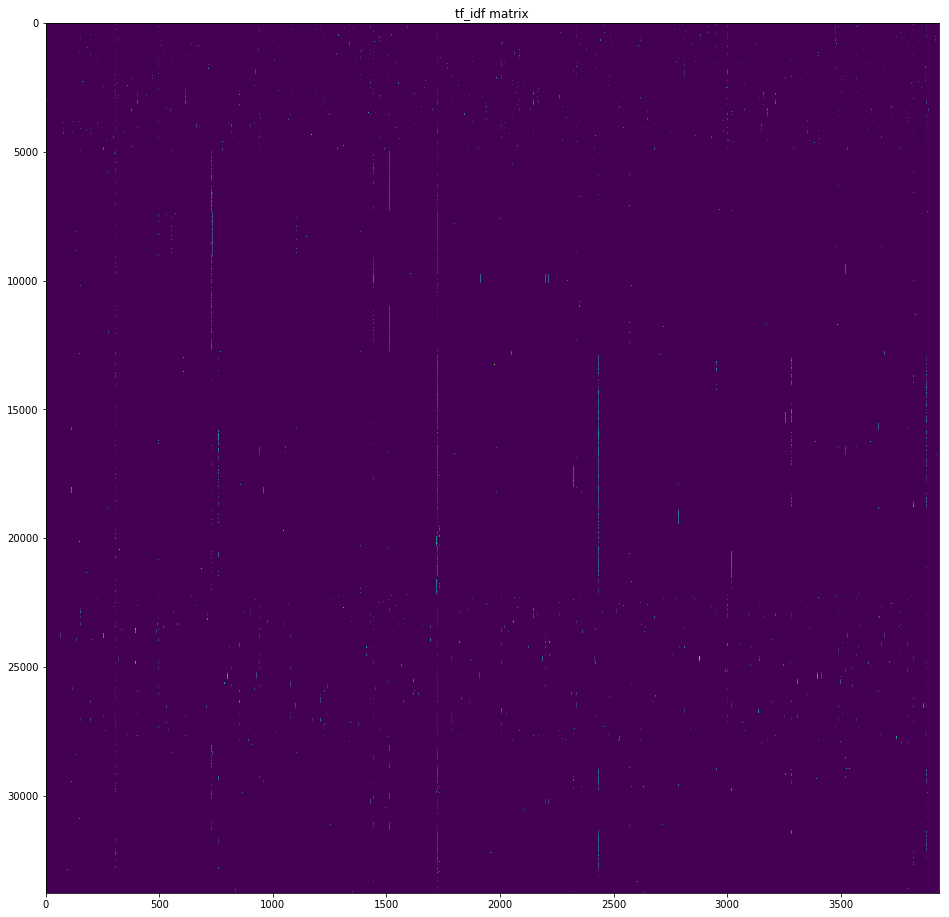

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(txt_tfidf.toarray(), cmap="viridis", aspect="auto")
plt.title("tf_idf matrix")

# Basic Clasifiers

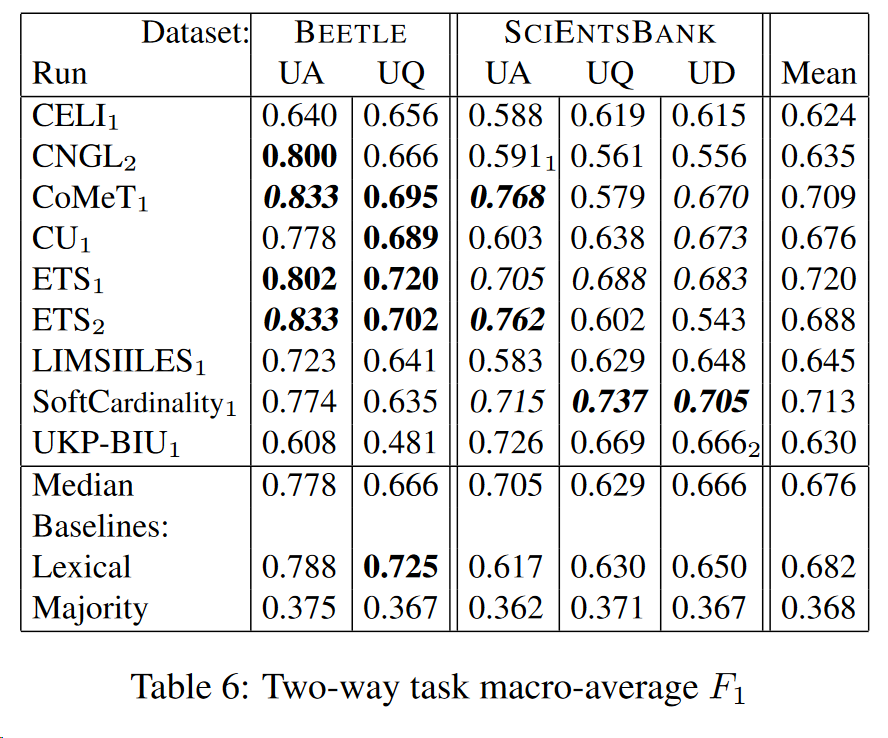

## 1. Naïve Bayes

In [15]:
gnb = GaussianNB()
predictor_GaussianNB= gnb.fit(train_tfidf.toarray(), train_tfidf_Y)
y_pred_GaussianNB= predictor_GaussianNB.predict(train_tfidf.toarray())
print("Number of mislabeled points out of a total %d points : %d" % (train_tfidf.shape[0],(train_tfidf_Y != y_pred_GaussianNB).sum()))

Number of mislabeled points out of a total 22167 points : 9394


In [16]:
print (f1_score(train_tfidf_Y, y_pred_GaussianNB, average='weighted'))

0.5282955841529756


In [17]:
y_test_GaussianNB = predictor_GaussianNB.predict(test_tfidf.toarray())
print (f1_score(test_tfidf_Y, y_test_GaussianNB, average='weighted'))

0.5371742724126949


In [21]:
test_divs=['TEST Beetle Unseen Answers',
           'TEST Beetle Unseen Questions',
           'TEST sciEntsBank Unseen Answers',
           'TEST sciEntsBank Unseen Questions',
           'TEST sciEntsBank Unseen Domains']

In [32]:
for test_class in test_divs:
    y_test_GaussianNB_class = predictor_GaussianNB.predict(test_tfidf.toarray()[test_answers["dtset"]==test_class])
    print(test_class, f1_score(test_tfidf_Y[test_answers["dtset"]==test_class], y_test_GaussianNB_class, average='weighted'))
    print(pd.crosstab(columns=test_tfidf_Y[test_answers["dtset"]==test_class], index=y_test_GaussianNB_class,margins=True))
    print("***********************************************************************")

TEST Beetle Unseen Answers 0.42554311959521074
st_ans_calif     0    1   All
row_0                        
0              195   16   211
1              911  740  1651
All           1106  756  1862
***********************************************************************
TEST Beetle Unseen Questions 0.4752690184528084
st_ans_calif     0     1   All
row_0                         
0              420   261   681
1             1570  1648  3218
All           1990  1909  3899
***********************************************************************
TEST sciEntsBank Unseen Answers 0.46807920454060514
st_ans_calif    0    1  All
row_0                      
0              84   47  131
1             223  186  409
All           307  233  540
***********************************************************************
TEST sciEntsBank Unseen Questions 0.5168486617535006
st_ans_calif    0    1  All
row_0                      
0             224  149  373
1             208  152  360
All           432  301  733